In [11]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import mxnet as mx
from mxnet import gluon
import gluonnlp as nlp

In [12]:

np.random.seed(100)
random.seed(100)
mx.random.seed(10000)
ctx = mx.gpu(0)

In [17]:
import os
DATA_DIR="."

# load Pickle file 
def load_ds(fname=os.path.join(DATA_DIR,'/atis.train.pkl'), verbose=True):
    with open(fname, 'rb') as stream:
        ds,dicts = pickle.load(stream)
    if verbose:
      print('Done  loading: ', fname)
      print('      samples: {:4d}'.format(len(ds['query'])))
      print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
      print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
      print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds,dicts
  
# convert Pickle file to arrays
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(DATA_DIR,filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

    if add_start_end_token:
        i2s[178] = 'BOS'
        i2s[179] = 'EOS'
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        if add_start_end_token:
            slot_text[0] = 'BOS'
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'
            slot_vector[-1]= 179
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
          print('Query text:', q)
          print('Query vector: ', query[i])
          print('Intent label: ', i2in[intent[i][0]])
          print('Slot text: ', slot)
          print('Slot vector: ', slot_vector)
          print('*'*74)
    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, query_data, intent_data, intent_data_label, slot_data
 

In [19]:
import pickle
# load ATIS training dataset
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

# load ATIS testing dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
input_tensor_test, target_tensor_test, \
query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')
  

Done  loading:  ./atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS what flights fly from denver to san francisco on monday tuesday wednesday thursday and friday EOS
Query vector:  [178 916 429 431 444 351 851 739 440 654 601 874 908 845 215 441 179]
Intent label:  flight
Slot text:  O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O B-depart_date.day_name B-depart_date.day_name B-depart_date.day_name B-depart_date.day_name O B-depart_date.day_name O
Slot vector:  [128, 128, 128, 128, 128, 48, 128, 78, 125, 128, 26, 26, 26, 26, 128, 26, 128]
**************************************************************************
Query text: BOS show me all flights from indianapolis EOS
Query vector:  [178 770 581 207 429 444 489 179]
Intent label:  flight
Slot text:  O O O O O O B-fromloc.city_name O
Slot vector:  [128, 128, 128, 128, 128, 128, 48, 128]
********************************************************************

In [21]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({'query': query_data_train, 'intent': intent_data_train, 'slot filling': slot_data_train})

df_small = pd.DataFrame(columns=['query','intent','slot filling'])
j = 0
for i in df.intent.unique():
  df_small.loc[j] = df[df.intent==i].iloc[0]
  j = j+1
  
df_small

,query,intent,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,flight,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,flight_time,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,aircraft,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,ground_service,O O O O O O O O B-city_name
5,what 's the airport at orlando,airport,O O O O O B-city_name
6,which airline serves denver pittsburgh and atlanta,airline,O O O B-fromloc.city_name B-fromloc.city_name O B-fromloc.city_name
7,how far is it from orlando airport to orlando,distance,O O O O O B-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name
8,what is fare code h,abbreviation,O O O O B-fare_basis_code
9,how much does the limousine service cost within pittsburgh,ground_fare,O O O O B-transport_type O O O B-city_name


In [22]:
i2s_train_values = list(i2s_train.values())
df3 = pd.DataFrame()
for i in range(7):
  df3[str(i)] = i2s_train_values[i*15:(i+1)*15]
df3

,0,1,2,3,4,5,6
0,B-aircraft_code,B-arrive_time.time_relative,B-depart_date.year,B-flight_time,B-return_date.day_name,B-today_relative,I-arrive_time.time_relative
1,B-airline_code,B-booking_class,B-depart_time.end_time,B-fromloc.airport_code,B-return_date.day_number,B-toloc.airport_code,I-city_name
2,B-airline_name,B-city_name,B-depart_time.period_mod,B-fromloc.airport_name,B-return_date.month_name,B-toloc.airport_name,I-class_type
3,B-airport_code,B-class_type,B-depart_time.period_of_day,B-fromloc.city_name,B-return_date.today_relative,B-toloc.city_name,I-cost_relative
4,B-airport_name,B-compartment,B-depart_time.start_time,B-fromloc.state_code,B-return_time.period_mod,B-toloc.country_name,I-depart_date.day_name
5,B-arrive_date.date_relative,B-connect,B-depart_time.time,B-fromloc.state_name,B-return_time.period_of_day,B-toloc.state_code,I-depart_date.day_number
6,B-arrive_date.day_name,B-cost_relative,B-depart_time.time_relative,B-meal,B-round_trip,B-toloc.state_name,I-depart_date.today_relative
7,B-arrive_date.day_number,B-day_name,B-economy,B-meal_code,B-state_code,B-transport_type,I-depart_time.end_time
8,B-arrive_date.month_name,B-day_number,B-fare_amount,B-meal_description,B-state_name,I-airline_name,I-depart_time.period_of_day
9,B-arrive_date.today_relative,B-days_code,B-fare_basis_code,B-mod,B-stoploc.airport_code,I-airport_name,I-depart_time.start_time


In [24]:
def max_length(tensor):
    return max(len(t) for t in tensor)

# Helper function to pad the query tensor and slot (target) tensor to the same length. 
# Also creates a tensor for teacher forcing.
def create_tensors(input_tensor, target_tensor, nb_sample=9999999, max_len=0):
    len_input, len_target  = max_length(input_tensor), max_length(target_tensor)
    len_input = max(len_input,max_len)
    len_target = max(len_target,max_len)
    

    # Padding the input and output tensor to the maximum length
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=len_input,
                                                                 padding='post')

    teacher_data = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=len_target , 
                                                                  padding='post')
    
    target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
    target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
    target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))
    
    nb = len(input_data)
    p = np.random.permutation(nb)
    input_data = input_data[p]
    teacher_data = teacher_data[p]
    target_data = target_data[p]

    return input_data[:min(nb_sample, nb)], teacher_data[:min(nb_sample, nb)], target_data[:min(nb_sample, nb)], len_input, len_target 
           

In [26]:
import tensorflow as tf
input_data_train, teacher_data_train, target_data_train, \
                  len_input_train, len_target_train  = create_tensors(input_tensor_train, target_tensor_train)
input_data_test, teacher_data_test, target_data_test, \
                 len_input_test, len_target_test  = create_tensors(input_tensor_test, target_tensor_test, max_len=len_input_train)

In [27]:

def get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test):
    vocab_in_size = len({**t2i_train, **t2i_test})
    vocab_out_size = len({**s2i_train, **s2i_test})
    return vocab_in_size, vocab_out_size
  
vocab_in_size, vocab_out_size = get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test)
vocab_in_size, vocab_out_size

(943, 129)

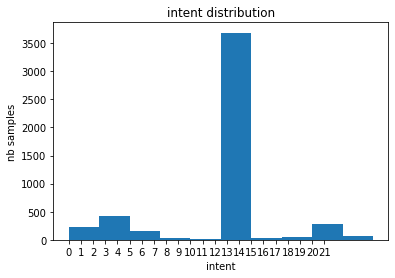

In [33]:
import matplotlib.pyplot as plt
labels = intent_data_label_train
plt.hist(labels)
plt.xlabel('intent')
plt.ylabel('nb samples')
plt.title('intent distribution')
plt.xticks(np.arange(len(np.unique(labels))));

In [48]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_in_size, embedding_dim, input_length=len_input_train))
model_lstm.add(LSTM(units))
model_lstm.add(Dense(22, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(input_data_train, intent_data_label_cat_train, 
                              epochs=10,batch_size=BATCH_SIZE)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 256)           241408    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1024)              5246976   
_________________________________________________________________
dense (Dense)                (None, 22)                22550     
Total params: 5,510,934
Trainable params: 5,510,934
Non-trainable params: 0
_________________________________________________________________


NameError: name 'intent_data_label_cat_train' is not defined

In [44]:
y = list(set(labels.flatten()))

In [45]:
y

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 19, 20, 21, 22, 23, 24, 25]

In [47]:
len(y)

22